In [1]:
import pickle
import numpy as np
import pickle
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Conv2DTranspose, UpSampling2D, MaxPooling2D 
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Input, Lambda, Dropout, concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score


def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def make_model(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='valid') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def get_iou(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_pred, y_true))
    union = np.sum(np.logical_or(y_pred, y_true))
    mask_sum = np.sum(np.abs(y_true)) + np.sum(np.abs(y_pred))
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    iou = np.mean(iou)
    return iou

def get_dice(im1, im2):
    
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())

/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-pack

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from color_deconvolution_2 import color_deconvolution
import time
#prepare the data
#  x data needs to be shape: (num_samples, 1025, 1025, 1) , ndtype= uint8
#  y data needs to be shape: (num_samples, 1025, 1025, 2) , ndtype = float64
#   channel 1 is 0. for background, 1. for foreground. channel 2 is just the inverse

im_loc = '/home/bkf15/akash_data/unet_data/images'
mask_loc = '/home/bkf15/akash_data/unet_data/masks'

num_samples = 1441
im_shape = (1025, 1025)

X = np.zeros((num_samples, im_shape[0], im_shape[1], 1), dtype=np.uint8)
y = np.zeros((num_samples, im_shape[0], im_shape[1], 2), dtype=np.float64)

for i, im_f in enumerate(os.listdir(im_loc)):
    s = time.time()
    im = np.asarray(Image.open(os.path.join(im_loc, im_f)))
    im_decon = color_deconvolution(im)[0]
    #convert to int8
    im_decon[im_decon > 255] = 255 #already in range (0,255) , just being safe
    im_decon[im_decon < 0] = 0
    im_int = np.expand_dims(im_decon.astype(np.uint8), axis=2)
    
    #find the mask
    mask_orig = np.asarray(Image.open(os.path.join(mask_loc, im_f))) #they have the same name 
    #need to convert it to a 2 channel im
    mask_tc = np.zeros((mask_orig.shape[0], mask_orig.shape[1], 2), dtype=np.float64)
    #first channel has 1.0 for lumen, 0. for background. 2nd channel is inverse 
    mask_tc[mask_orig, 0] = 1.0
    mask_tc[~mask_orig, 1] = 1.0
    
    X[i] = im_int
    y[i] = mask_tc
    
    print('Image {0} took {1:.2f} seconds.'.format(i, time.time()-s))
    
#save the data
with open('unet_data/prepared_ims.pickle', 'wb') as f:
    pickle.dump(X, f, protocol=4)
with open('unet_data/prepared_masks.pickle', 'wb') as f:
    pickle.dump(y, f, protocol=4)

In [2]:
#read in the pickled data, make train test split
with open('unet_data/prepared_ims.pickle', "rb") as input_file:
    X = pickle.load(input_file)

with open('unet_data/prepared_masks.pickle', "rb") as input_file:
    y = pickle.load(input_file)
    
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (1441, 1025, 1025, 1)
y shape: (1441, 1025, 1025, 2)


In [ ]:
#Do some data augmentation (rotation, add noise?)
plt.rcParams['figure.figsize'] = [15, 8]

num_samples = 1441
im_shape = (1025, 1025)
print('X shape before: {}'.format(X.shape))
print('y shape before: {}'.format(y.shape))

#faster to make new empty arrays and fill them, instead of concatting
new_X = np.zeros((num_samples*4, im_shape[0], im_shape[1], 1), dtype=np.uint8)
new_y = np.zeros((num_samples*4, im_shape[0], im_shape[1], 2), dtype=np.float64)
end = num_samples
for i in range(len(X)):
    t_x = X[i]
    t_y = y[i]
    new_X[i] = t_x
    new_y[i] = t_y
    for j in range(3):
        t_x = np.rot90(t_x)
        t_y = np.rot90(t_y)
        #X = np.concatenate((X, np.expand_dims(t_x, axis=0)))
        #y = np.concatenate((y, np.expand_dims(t_y, axis=0)))
        new_X[end] = t_x
        new_y[end] = t_y
        end += 1
print('X shape after augmentation: {}'.format(new_X.shape))
print('y shape after augmentation: {}'.format(new_y.shape))

In [ ]:
X = new_X
y = new_y

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

X train shape: (1080, 1025, 1025, 1)
X test shape: (361, 1025, 1025, 1)
y train shape: (1080, 1025, 1025, 2)
y test shape: (361, 1025, 1025, 2)


In [ ]:
model = make_model(Input((1025, 1025, 1), name='img'))
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/best_unet',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(X_train, y_train, nb_epoch=10 ,batch_size=32, shuffle=True, 
          validation_split = 0.1, verbose=1, callbacks=[])

Y_hat = model.predict(X_test, verbose=1)
unet_seg_test = (Y_hat > 0.5).astype(np.uint8)
pixel_acc_unet = []
for i in range(X_test.shape[0]):

    get_acc1 = 0;
    get_acc2 = 0;

    y_true_unet = y_test[i,:,:,:]

    y_pred_unet = unet_seg_test[i,:,:,:]
    y_true_unet = y_true_unet.flatten()
    y_pred_unet = y_pred_unet.flatten()

    get_acc1 = accuracy_score(y_true_unet, y_pred_unet)
    pixel_acc_unet.append(get_acc1)
print("mean of pixel accuracy for unet = "+str(np.mean(pixel_acc_unet)))
print("std of pixel accuracy for unet = "+str(np.std(pixel_acc_unet)))

iou_unet = []
for i in range(X_test.shape[0]):

    y_true_unet = y_test[i,:,:,]
    y_pred_unet = unet_seg_test[i,:,:,:]
    y_true_unet = y_true_unet.flatten()    
    y_pred_unet = y_pred_unet.flatten()

    get_iou1 = get_iou(y_true_unet, y_pred_unet);
    iou_unet.append(get_iou1)

print("mean of iou for unet = "+str(np.mean(iou_unet)))
print("std of iou for unet = "+str(np.std(iou_unet)))

dice_score_unet = []
for i in range(X_test.shape[0]):

    y_true_unet = y_test[i,:,:,]
    y_pred_unet = unet_seg_test[i,:,:,:]
    y_true_unet = y_true_unet.flatten()
    y_pred_unet = y_pred_unet.flatten()

    get_dice1 = get_dice(y_true_unet, y_pred_unet)
    dice_score_unet.append(get_dice1)

print("mean of dice score for gmm = "+str(np.mean(dice_score_unet)))
print("std of dice score for gmm = "+str(np.std(dice_score_unet)))  



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':



Train on 972 samples, validate on 108 samples
Epoch 1/10
416/972 [===========>..................] - ETA: 35:17 - loss: 1.0626 - accuracy: 0.2280

In [ ]:
model.save_weights('models/unet')

In [4]:
model = make_model(Input((1025, 1025, 1), name='img'))

# Restore the weights
model.load_weights('models/best_unet')

In [5]:
Y_hat = model.predict(X_test, verbose=1)
unet_seg_test = (Y_hat > 0.5).astype(np.uint8)


361/361 [==============================] - 189s 525ms/step


In [6]:
pixel_acc_unet = []
for i in range(X_test.shape[0]):

    get_acc1 = 0;
    get_acc2 = 0;

    y_true_unet = y_test[i,:,:,:]

    y_pred_unet = unet_seg_test[i,:,:,:]
    y_true_unet = y_true_unet.flatten()
    y_pred_unet = y_pred_unet.flatten()

    get_acc1 = accuracy_score(y_true_unet, y_pred_unet)
    pixel_acc_unet.append(get_acc1)
print("mean of pixel accuracy for unet = "+str(np.mean(pixel_acc_unet)))
print("std of pixel accuracy for unet = "+str(np.std(pixel_acc_unet)))

iou_unet = []
for i in range(X_test.shape[0]):

    y_true_unet = y_test[i,:,:,]
    y_pred_unet = unet_seg_test[i,:,:,:]
    y_true_unet = y_true_unet.flatten()    
    y_pred_unet = y_pred_unet.flatten()

    get_iou1 = get_iou(y_true_unet, y_pred_unet);
    iou_unet.append(get_iou1)

print("mean of iou for unet = "+str(np.mean(iou_unet)))
print("std of iou for unet = "+str(np.std(iou_unet)))

dice_score_unet = []
for i in range(X_test.shape[0]):

    y_true_unet = y_test[i,:,:,]
    y_pred_unet = unet_seg_test[i,:,:,:]
    y_true_unet = y_true_unet.flatten()
    y_pred_unet = y_pred_unet.flatten()

    get_dice1 = get_dice(y_true_unet, y_pred_unet)
    dice_score_unet.append(get_dice1)

print("mean of dice score for gmm = "+str(np.mean(dice_score_unet)))
print("std of dice score for gmm = "+str(np.std(dice_score_unet)))  

mean of pixel accuracy for unet = 0.9432054379977621
std of pixel accuracy for unet = 0.07806898796491679
mean of iou for unet = 0.8992553208859296
std of iou for unet = 0.12483553213127946


/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/bkf15/anaconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:90: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


mean of dice score for gmm = 0.9416883622511188
std of dice score for gmm = 0.08058342681166232


In [ ]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 20]

#pick 10 random images to view
for i in range(10):
    r = random.randint(0, X_test.shape[0])
    samp_x = X_test[r]
    samp_y_gt = y_test[r,:,:,0]
    samp_y_hat = Y_hat[r,:,:,0]
    plt.subplot(2,2,1)
    plt.title('Ground truth')
    plt.imshow(samp_x, cmap='gray')
    plt.imshow(samp_y_gt,  cmap='jet', alpha=0.5)
    plt.subplot(2,2,2)
    plt.title('Unet prediction')
    plt.imshow(samp_x, cmap='gray')
    plt.imshow(samp_y_hat,  cmap='jet', alpha=0.5)
    plt.subplots_adjust(right=0.5)
    plt.show()

In [ ]:
############################################
# ICCV 2021 RELATED CODE
#############################################

In [2]:
#prepare the ICCV data for inference
import matplotlib.pyplot as plt
import os
from PIL import Image
from color_deconvolution_2 import color_deconvolution
import time
im_loc = '/home/bkf15/akash_data/ICCV_data_ducts'

num_samples = 4853
im_shape = (1025, 1025)

X_iccv = np.zeros((num_samples, im_shape[0], im_shape[1], 1), dtype=np.uint8)
#orig_ims = [] #unblurred ims
im_names = []
s = time.time()
for i, im_f in enumerate(os.listdir(im_loc)):
    im_names.append(im_f)
    im = Image.open(os.path.join(im_loc, im_f))
    #orig_ims.append(im)
    im_small = np.asarray(im.resize((256,256)))
    #im = np.asarray(Image.open(os.path.join(im_loc, im_f)).resize((256,256)))
    im_decon = color_deconvolution(im_small)[0]
    im_decon_re = np.asarray(Image.fromarray(im_decon).resize(im_shape)).copy()
    #convert to int8
    im_decon_re[im_decon_re > 255] = 255 #already in range (0,255) , just being safe
    im_decon_re[im_decon_re < 0] = 0
    im_int = np.expand_dims(im_decon_re.astype(np.uint8), axis=2)
    X_iccv[i] = im_int
    
    if i % 100 == 0:
        print('Image {0} of {1} took {2:.2f} seconds.'.format(i, num_samples, time.time()-s))
        s = time.time()
    
# #save the data
with open('unet_data/iccv_prepared_ims.pickle', 'wb') as f:
    pickle.dump(X_iccv, f, protocol=4)

Image 0 of 4853 took 1.34 seconds.
Image 100 of 4853 took 132.20 seconds.
Image 200 of 4853 took 131.45 seconds.
Image 300 of 4853 took 131.32 seconds.
Image 400 of 4853 took 131.66 seconds.
Image 500 of 4853 took 132.29 seconds.
Image 600 of 4853 took 132.02 seconds.
Image 700 of 4853 took 132.27 seconds.
Image 800 of 4853 took 130.77 seconds.
Image 900 of 4853 took 129.98 seconds.
Image 1000 of 4853 took 131.16 seconds.
Image 1100 of 4853 took 130.99 seconds.
Image 1200 of 4853 took 130.43 seconds.
Image 1300 of 4853 took 131.87 seconds.
Image 1400 of 4853 took 130.88 seconds.
Image 1500 of 4853 took 132.06 seconds.
Image 1600 of 4853 took 134.13 seconds.
Image 1700 of 4853 took 132.32 seconds.
Image 1800 of 4853 took 131.00 seconds.
Image 1900 of 4853 took 130.42 seconds.
Image 2000 of 4853 took 130.83 seconds.
Image 2100 of 4853 took 134.83 seconds.
Image 2200 of 4853 took 131.98 seconds.
Image 2300 of 4853 took 130.78 seconds.
Image 2400 of 4853 took 129.31 seconds.
Image 2500 of 

Done 10 of 4853 in 21.13 seconds.
Done 20 of 4853 in 36.64 seconds.
Done 30 of 4853 in 52.02 seconds.
Done 40 of 4853 in 66.95 seconds.
Done 50 of 4853 in 82.43 seconds.
Done 60 of 4853 in 97.82 seconds.
Done 70 of 4853 in 113.22 seconds.
Done 80 of 4853 in 128.58 seconds.
Done 90 of 4853 in 143.8 seconds.
Done 100 of 4853 in 159.14 seconds.
Done 110 of 4853 in 174.32 seconds.
Done 120 of 4853 in 189.78 seconds.
Done 130 of 4853 in 205.42 seconds.
Done 140 of 4853 in 221.05 seconds.
Done 150 of 4853 in 236.38 seconds.
Done 160 of 4853 in 251.83 seconds.
Done 170 of 4853 in 267.2 seconds.
Done 180 of 4853 in 282.42 seconds.
Done 190 of 4853 in 297.78 seconds.
Done 200 of 4853 in 312.91 seconds.
Done 210 of 4853 in 328.51 seconds.
Done 220 of 4853 in 343.93 seconds.
Done 230 of 4853 in 359.75 seconds.
Done 240 of 4853 in 375.25 seconds.
Done 250 of 4853 in 390.79 seconds.
Done 260 of 4853 in 406.21 seconds.
Done 270 of 4853 in 421.79 seconds.
Done 280 of 4853 in 437.23 seconds.
Done 290 

Done 2220 of 4853 in 3605.0 seconds.
Done 2230 of 4853 in 3619.71 seconds.
Done 2240 of 4853 in 3634.29 seconds.
Done 2250 of 4853 in 3648.98 seconds.
Done 2260 of 4853 in 3663.85 seconds.
Done 2270 of 4853 in 3679.17 seconds.
Done 2280 of 4853 in 3694.06 seconds.
Done 2290 of 4853 in 3708.74 seconds.
Done 2300 of 4853 in 3723.47 seconds.
Done 2310 of 4853 in 3738.19 seconds.
Done 2320 of 4853 in 3752.72 seconds.
Done 2330 of 4853 in 3767.86 seconds.
Done 2340 of 4853 in 3782.26 seconds.
Done 2350 of 4853 in 3797.15 seconds.
Done 2360 of 4853 in 3812.12 seconds.
Done 2370 of 4853 in 3826.8 seconds.
Done 2380 of 4853 in 3841.19 seconds.
Done 2390 of 4853 in 3856.27 seconds.
Done 2400 of 4853 in 3871.09 seconds.
Done 2410 of 4853 in 3885.67 seconds.
Done 2420 of 4853 in 3900.07 seconds.
Done 2430 of 4853 in 3915.05 seconds.
Done 2440 of 4853 in 3929.39 seconds.
Done 2450 of 4853 in 3943.9 seconds.
Done 2460 of 4853 in 3958.47 seconds.
Done 2470 of 4853 in 3973.39 seconds.
Done 2480 of 48

Done 4390 of 4853 in 7039.58 seconds.
Done 4400 of 4853 in 7055.23 seconds.
Done 4410 of 4853 in 7071.18 seconds.
Done 4420 of 4853 in 7087.08 seconds.
Done 4430 of 4853 in 7102.82 seconds.
Done 4440 of 4853 in 7118.69 seconds.
Done 4450 of 4853 in 7134.18 seconds.
Done 4460 of 4853 in 7149.63 seconds.
Done 4470 of 4853 in 7165.45 seconds.
Done 4480 of 4853 in 7180.9 seconds.
Done 4490 of 4853 in 7196.46 seconds.
Done 4500 of 4853 in 7212.11 seconds.
Done 4510 of 4853 in 7227.94 seconds.
Done 4520 of 4853 in 7243.3 seconds.
Done 4530 of 4853 in 7258.86 seconds.
Done 4540 of 4853 in 7274.71 seconds.
Done 4550 of 4853 in 7290.41 seconds.
Done 4560 of 4853 in 7305.83 seconds.
Done 4570 of 4853 in 7321.34 seconds.
Done 4580 of 4853 in 7337.06 seconds.
Done 4590 of 4853 in 7352.86 seconds.
Done 4600 of 4853 in 7368.26 seconds.
Done 4610 of 4853 in 7383.68 seconds.
Done 4620 of 4853 in 7399.45 seconds.
Done 4630 of 4853 in 7415.22 seconds.
Done 4640 of 4853 in 7430.96 seconds.
Done 4650 of 4

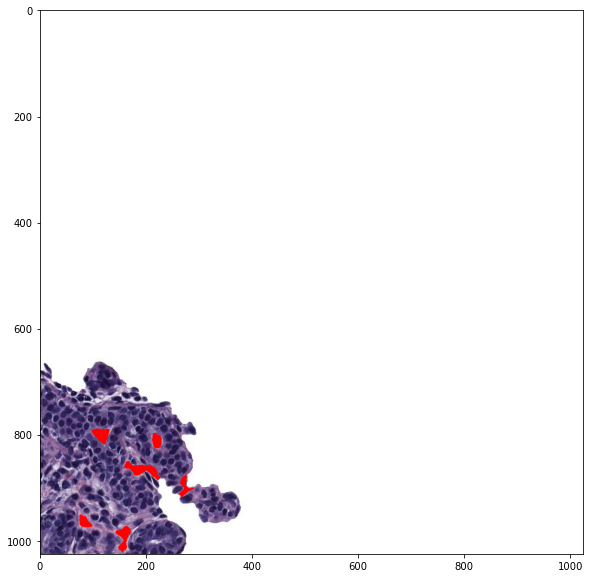

In [54]:
#Read in prepared ICCV images, predict masks, and save results 

import pickle
import time
from skimage.morphology import binary_dilation, binary_erosion, area_opening
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
# with open('unet_data/iccv_prepared_ims.pickle', "rb") as input_file:
#     X = pickle.load(input_file)
X = X_iccv

model = make_model(Input((1025, 1025, 1), name='img'))
# Restore the weights
model.load_weights('models/best_unet')

#list of all the mask files
mask_dir = '/mnt/data2/ICCV_lumen/duct_masks/ICCV_data_duct_masks'
masks = os.listdir(mask_dir)
out_dir = '/mnt/data2/ICCV_lumen/lumen_masks'
original_images = os.listdir('ICCV_data_ducts')

threshold = 0.25

Y_hat = model.predict(X, verbose=1)

s = time.time()
for i, x_i in enumerate(X):   #or, do the predictions one by one
    x_i_d = np.expand_dims(x_i, axis=0)
    y_i = model.predict(x_i_d)[0]
    lumen_pred = y_i[:,:,0].copy()
    
    #mask out non duct pixels
    im_name = im_names[i][:-4]
    mask = np.asarray(Image.open(os.path.join(mask_dir, [m for m in masks if im_name in m][0])).resize((1025,1025)))
    mask = mask[:,:,0]
    lumen_pred[mask>0] = 0
    
    #threshold + morphology
    lumen_mask = (lumen_pred > threshold).astype(np.uint8) * 255
    for _ in range(3):
        lumen_mask = binary_dilation(lumen_mask)
    for _ in range(5):
        lumen_mask = binary_erosion(lumen_mask)
    lumen_mask = area_opening(lumen_mask, 250)
    
    #create display image and save
    disp_im = np.asarray(Image.open('ICCV_data_ducts/' + [o_im for o_im in original_images if im_name in o_im][0]).resize((1025,1025))).copy()
    disp_im[lumen_mask] = (255,0,0)
    #plt.imshow(disp_im)
    Image.fromarray(disp_im).save(os.path.join(out_dir, 'disp_ims', im_name + '_lumen_drawing.jpg'))
    
    #save
    Image.fromarray(lumen_mask).save(os.path.join(out_dir, im_name[:-9] + '_lumen_seg.png'))
    
    if i > 0 and i % 10 == 0:
        print(f'Done {i} of {len(X)} in {round(time.time() - s, 2)} seconds.')

In [ ]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

import pickle
with open('unet_data/iccv_prepared_ims.pickle', "rb") as input_file:
    X = pickle.load(input_file)

#open y predictions, if possible
# with open('ICCV_lumen_segs/lumen_predictions.pickle', 'rb') as f:
#     Y_hat = pickle.load(f)

#do the thresholding
threshold = 0.25
lumen_masks_nonthresh = (Y_hat[:,:,:,0] * 255).astype(np.uint8)
#lumen_masks = lumen_masks_nonthresh > (threshold * 255)

#lumen_masks = lumen_masks[:,:,:,0]
#lumen_masks[lumen_masks > 0] = 1
#lumen_masks = (lumen_masks * 255).astype(np.uint8)

#pick 10 random images to view
for i in range(10):
    r = random.randint(0, X.shape[0])
    samp_x = orig_ims[r]
    samp_y_hat = lumen_masks_nonthresh[r]
    plt.title(f'Unet prediction for {im_names[r]}')
    plt.imshow(samp_x, cmap='gray')
    plt.imshow(samp_y_hat, alpha=0.5)
    plt.show()

In [ ]:
#save the results on iccv images
out_dir = '/mnt/data2/ICCV_lumen/lumen_masks'
#list of all the mask files
mask_dir = '/mnt/data2/ICCV_lumen/duct_masks/ICCV_data_duct_masks'
masks = os.listdir(mask_dir)
for i in range(len(Y_hat)):
    im_name = im_names[i][:-4]
    mask = np.asarray(Image.open(os.path.join(mask_dir, [m for m in masks if im_name in m][0])).resize((1025,1025)))
    mask = mask[:,:,0]
    save_im = lumen_masks[i]
    save_im[mask>0] = 0 #mask out all but the duct
    Image.fromarray(save_im).save(os.path.join(out_dir, im_name + '_lumen_seg.png'))
    break
    
    #Image.fromarray((Y_hat[i,:,:,0] * 255).astype(np.uint8)).convert('L').save(os.path.join(out_dir, im_names[i] + '.png'))
# with open('ICCV_lumen_segs/lumen_predictions.pickle', 'wb') as f:
#     pickle.dump(Y_hat, f, protocol=4)

In [40]:
im_name = im_names[i][:-4]
print(im_name[:-9])

adh25-1a_seg31
